# Component Identification Greedy (VizMod)

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
import json

In [2]:
def get_element_xpath(driver, element):
    # Returns an absolute XPath for the given WebElement
    script = '''
    function getElementXPath(elt) {
        if (elt.id) {
            return 'id("' + elt.id + '")';
        }
        const parts = [];
        while (elt && elt.nodeType === Node.ELEMENT_NODE) {
            let tagName = elt.tagName.toLowerCase();
            let idx = 1, sib = elt.previousSibling;
            while (sib) {
                if (sib.nodeType === Node.ELEMENT_NODE && sib.tagName.toLowerCase() === tagName) {
                    idx++;
                }
                sib = sib.previousSibling;
            }
            parts.unshift(tagName + '[' + idx + ']');
            elt = elt.parentNode;
        }
        return '/' + parts.join('/');
    }
    return getElementXPath(arguments[0]);
    '''
    return driver.execute_script(script, element)

In [3]:
def compute_modularization_potential(driver, leaf_xpaths, max_iters=50):
    """
    Given a list of XPath locators for "leaf" visual elements,
    iteratively climb the DOM from each leaf to parent nodes,
    computing at each level the "modularization potential" score:
        score = \prod_{node in level} (number_of_leaf_descendants(node))
    Returns the best iteration index, the list of scores, and
a mapping of the best-level node XPaths to their descendant counts.
    """
    
    # Initialize count per leaf element
    nodes_to_count = {}
    for xp in leaf_xpaths:
        try:
            el = driver.find_element(By.XPATH, xp)
            nodes_to_count[el] = 1
        except Exception as e:
            print(f"[WARN] Could not locate leaf XPath {xp}: {e}")

    scores = []
    instances = []

    for iteration in range(max_iters):
        # Compute product-of-counts score
        score = 1
        for count in nodes_to_count.values():
            score *= count
        scores.append(score)
        instances.append(dict(nodes_to_count))

        # Build next-level counts by grouping leaves under their parent
        parent_counts = {}
        for el, count in nodes_to_count.items():
            try:
                parent = el.find_element(By.XPATH, '..')
            except NoSuchElementException:
                continue
            if parent.tag_name.lower() == 'html':
                continue  # stop at <html>
            parent_counts[parent] = parent_counts.get(parent, 0) + count

        if not parent_counts:
            break
        nodes_to_count = parent_counts

    # Identify the iteration with maximal score
    best_iter = max(range(len(scores)), key=lambda i: scores[i])
    best_nodes = instances[best_iter]

    # Convert WebElements to XPath strings for output
    result = {}
    for el, count in best_nodes.items():
        if count > 1:
            xp = get_element_xpath(driver, el)
            result[xp] = count

    return best_iter, scores, result

In [4]:
URL = "https://github.com/facebook"
folder_name = URL.rstrip("/").replace("://","_").replace("/","_")


# --- Load leaf XPaths from elements.json ---
with open(f'{folder_name}/elements.json', 'r', encoding='utf-8') as f:
    elements = json.load(f)
leaf_xpaths = [el['xpath'] for el in elements]
print(f"Loaded {len(leaf_xpaths)} leaf XPaths from elements.json")

# --- Configure WebDriver ---
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless=new')
chrome_options.add_argument('--window-size=1280,800')
driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=chrome_options
)

# --- Load target page ---
driver.get(URL)

# --- Run modularization analysis ---
best_level, scores, instances = compute_modularization_potential(driver, leaf_xpaths)
print(f"Best modularization at iteration {best_level}, score: {scores[best_level]}")
for xpath, cnt in instances.items():
    print(f"{xpath} -> {cnt} elements")

driver.quit()


Loaded 369 leaf XPaths from elements.json
[WARN] Could not locate leaf XPath /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[1]/div[1]/div[1]/div[3]/div[1]/div[2]/div[1]/div[1]/ul[1]/li[1]/div[1]/div[2]/a[5]: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[1]/div[1]/div[1]/div[3]/div[1]/div[2]/div[1]/div[1]/ul[1]/li[1]/div[1]/div[2]/a[5]"}
  (Session info: chrome=135.0.7049.115); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x0000000103d582c8 chromedriver + 6197960
1   chromedriver                        0x0000000103d4f8ea chromedriver + 6162666
2   chromedriver                        0x00000001037d4de0 chromedriver + 417248
3   chromedriver                        0x0000000103826797 chromedriver + 751511
4   chromedriver    

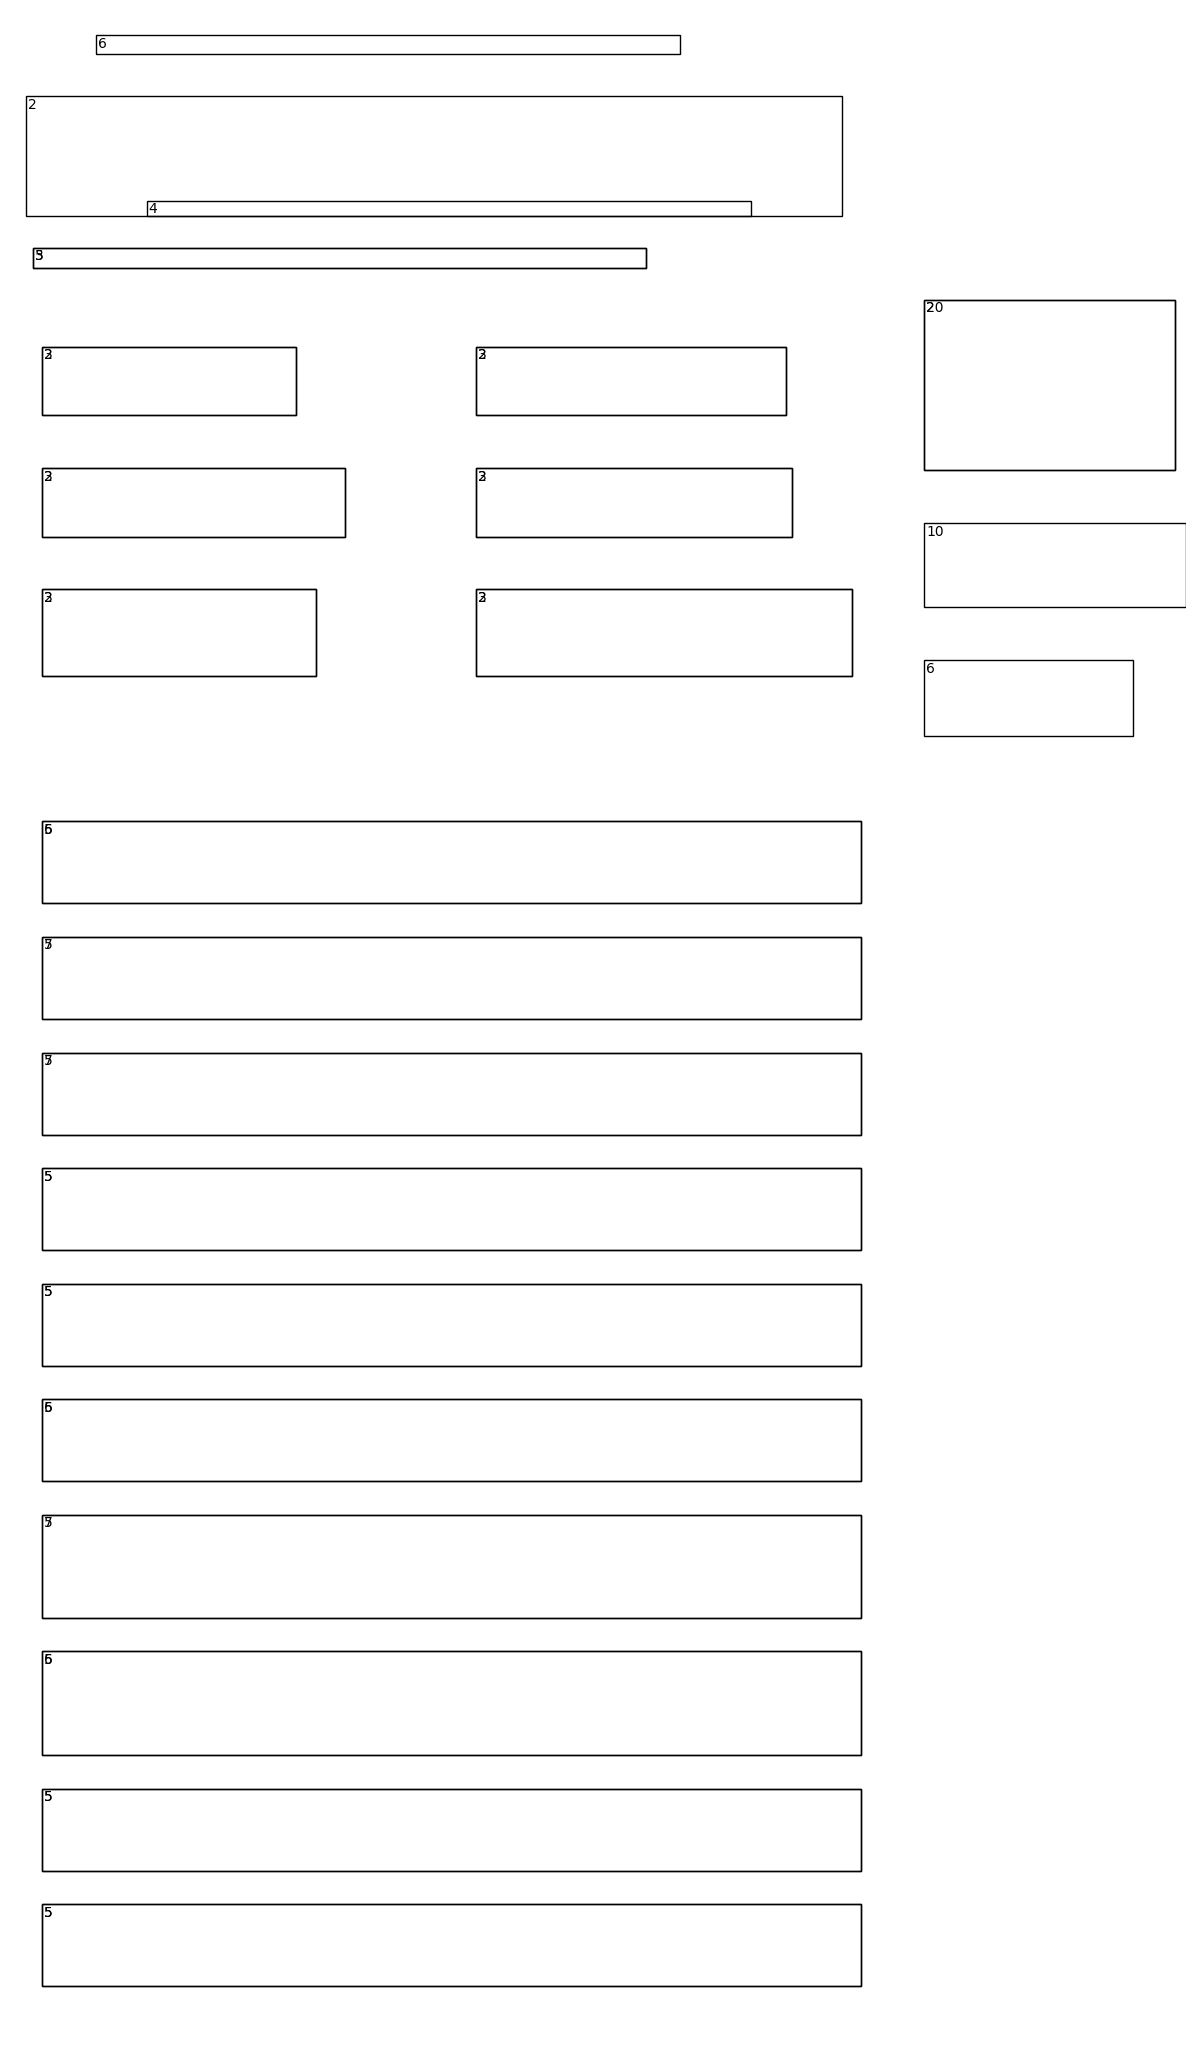

In [5]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- 1) Load your visual leaves data ---
with open(f'{folder_name}/elements.json', 'r', encoding='utf-8') as f:
    leaves = json.load(f)

# --- 2) Paste in your best‐level mapping here ---
#    (or load from a JSON you dumped in your traversal script)
best_level = instances

# --- 3) For each root, collect all leaves under it and compute its bbox ---
root_boxes = []
for root_xpath, count in best_level.items():
    # find only those leaves whose xpath starts with the root_xpath
    group = [l for l in leaves if l['xpath'].startswith(root_xpath)]
    if not group:
        continue
    min_x = min(l['x'] for l in group)
    min_y = min(l['y'] for l in group)
    max_x = max(l['x'] + l['width'] for l in group)
    max_y = max(l['y'] + l['height'] for l in group)
    root_boxes.append((min_x, min_y, max_x - min_x, max_y - min_y, count))

# --- 4) Determine canvas size from all leaves ---
all_max_x = max(l['x'] + l['width'] for l in leaves)
all_max_y = max(l['y'] + l['height'] for l in leaves)

# --- 5) Draw it!
fig, ax = plt.subplots(figsize=(all_max_x/100, all_max_y/100))
ax.set_xlim(0, all_max_x)
ax.set_ylim(all_max_y, 0)            # flip Y so (0,0) is top‑left
ax.axis('off')

for x, y, w, h, cnt in root_boxes:
    # outline
    rect = Rectangle((x, y), w, h, fill=False)
    ax.add_patch(rect)
    # label the count in top‑left corner
    ax.text(x + 2, y + 12, str(cnt), fontsize=10)

plt.tight_layout()
plt.show()


In [6]:
# 'leaves' is the list you loaded from elements.json
# each item has at least 'xpath', plus its x/y/width/height, etc.
with open(f'{folder_name}/elements.json','r',encoding='utf-8') as f:
    leaves = json.load(f)

# group leaf XPaths under each root‑XPath
instance_details = {}
for root_xpath, count in instances.items():
    grouped = [l for l in leaves if l['xpath'].startswith(root_xpath)]
    instance_details[root_xpath] = {
        'count':  count,
        'leaves': [l['xpath'] for l in grouped]
    }

# pretty‑print
for root, info in instance_details.items():
    print(f"{root} → {info['count']} elements:")
    for leaf_xp in info['leaves']:
        print("    ", leaf_xp)

/html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1] → 6 elements:
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[1]/button[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[2]/button[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[3]/button[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[4]/button[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[5]/button[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[6]/a[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[1]/button[1]/svg[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[2]/button[1]/svg[1]
     /html[1]/body[1]/div[1]/div[1]/header[1]/div[1]/div[3]/div[1]/nav[1]/ul[1]/li[3]/button[1]/svg[1]
     /html[1]/body[1]/div[1]/div[1]/h